# Mini Lab 8: All Things spaCy

<a target="_blank" href="https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_08_All_Things_spaCy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Unlike the preceding labs, this one isn't focused on a specific method. Instead, it is intended to walk you though some of the cababilities of spaCy's core models. By becoming more familiar with the posibilities, this may also inspire some ideas for your own projects.

The notebook is adapted from code authored by [Jonathan Reeve](http://jonreeve.com) ([Group for Experimental Methods in the Humanities](http://xpmethod.plaintext.in/), Columbia University). All code here is licensed under the MIT License.

It provides examples and code snippets for using spaCy's core models and their outputs including:

*   word tokenization
*   sentence tokenization
*   named entities
*   dependency parsing
*   word embeddings
*   document vectorization

For this, we'll be using the `en_core_web_md` model. Note that the English core models come in [three sizes](https://spacy.io/models/en) with different compontents.

## Download the model

We start by downloading the model and importing the necessary libraries.

In [1]:
%%capture
!python -m spacy download en_core_web_md

In [1]:
# for nlp tasks
import spacy
# for importing and pre-processing text
import re
import urllib.request
# for data frame manipulation
import pandas as pd
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
# for computation and statistics
import numpy as np
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

## The processing pipeline

Now we can instantiate our model instance and fetch our texts.

In [2]:
nlp = spacy.load('en_core_web_md')

### Read in the texts

The sample data is the script of the 1975 film _Monty Python and the Holy Grail_, taken from the NLTK Book corpus, and the Project Gutenberg edition of Jane Austen's novel *Pride and Prejudice*.

We'll begin by reading in the text.

In [3]:
grail_url = 'https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_text/grail.txt'
pride_url = 'https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_text/pride.txt'

In [4]:
with urllib.request.urlopen(grail_url) as response:
            grail_raw = response.read().decode('utf-8')

with urllib.request.urlopen(pride_url) as response:
            pride_raw = response.read().decode('utf-8')

We will also import presidential inaugural speeches from `nltk` (Natural Language Toolkit) [data](https://www.nltk.org/book/ch02.html):

In [ ]:
import nltk
nltk.download('inaugural')
from nltk.corpus import inaugural

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


In [ ]:
inaugural.fileids()[:10]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt']

### Pre-processing the texts

Note that the screenplay text has notations for who is delivering the line as well as off-stage direction. (No surprise!) If we were to pass the text as is to the model, all of that information would, of course, be parsed.

In [ ]:
grail_raw[:500]

'SCENE 1: [wind] [clop clop clop] \nKING ARTHUR: Whoa there!  [clop clop clop] \nSOLDIER #1: Halt!  Who goes there?\nARTHUR: It is I, Arthur, son of Uther Pendragon, from the castle of Camelot.  King of the Britons, defeator of the Saxons, sovereign of all England!\nSOLDIER #1: Pull the other one!\nARTHUR: I am, ...  and this is my trusty servant Patsy.  We have ridden the length and breadth of the land in search of knights who will join me in my court at Camelot.  I must speak with your lord and mast'

Depending on our task, we may want to do just that. But for the purposes of this excercise, we'll omit those parts of the text and retain just the dialogue.

We will also get rid of extra spaces and carriage returns using the `join` function. This will help with the reliability of the parsing.

In [ ]:
grail_raw = re.sub(r'\n.*?: ', ' ', grail_raw)
grail_raw = re.sub(r'^.*?: ', ' ', grail_raw)
grail_raw = re.sub(r'\[.*?\]', ' ', grail_raw)
grail_raw = " ".join(grail_raw.split()).strip()

We have no stage directions in the *Pride & Prejudice* data, but we'll remove the carriage returns, etc. for that text, as well.

In [ ]:
pride_raw = " ".join(pride_raw.split()).strip()

Now we can check what we've done:

In [ ]:
grail_raw[:500]

"Whoa there! Halt! Who goes there? It is I, Arthur, son of Uther Pendragon, from the castle of Camelot. King of the Britons, defeator of the Saxons, sovereign of all England! Pull the other one! I am, ... and this is my trusty servant Patsy. We have ridden the length and breadth of the land in search of knights who will join me in my court at Camelot. I must speak with your lord and master. What? Ridden on a horse? Yes! You're using coconuts! What? You've got two empty halves of coconut and you'r"

We will do the same for the inaugural data. But since we have a bunch of texts, we'll put them into a data frame, where we can set up some meta data taken from the file names.

In [ ]:
files = inaugural.fileids()
# There are some encoding errors in the inaugural data so encode then decode
texts = [inaugural.raw(file).encode('latin-1').decode('utf-8', errors='ignore') for file in files]
years = [int(file[:-4].split("-")[0]) for file in files]
presidents = [file[:-4].split("-")[1] for file in files]
df = pd.DataFrame({
    "year": years,
    "president": presidents,
    "file": files,
    "text": texts
})
# Pre-process the text data
df['text'] = df.text.apply(lambda x: " ".join(x.split()))
df.tail() # print last few files

,year,president,file,text
55,2009,Obama,2009-Obama.txt,My fellow citizens: I stand here today humbled...
56,2013,Obama,2013-Obama.txt,Thank you. Thank you so much. Vice President B...
57,2017,Trump,2017-Trump.txt,"Chief Justice Roberts, President Carter, Presi..."
58,2021,Biden,2021-Biden.txt,"Chief Justice Roberts, Vice President Harris, ..."
59,2025,Trump,2025-Trump.txt,"Thank you. Thank you very much, everybody. Wow..."


And we'll subset data from the 20th century on:

In [ ]:
inaugural_subset = df[df['year'] >= 1900]

### Parsing the texts

Now, we can parse the texts. This should take roughly 30 seconds...

In [5]:
%%time
grail = nlp(grail_raw)
pride = nlp(pride_raw)

CPU times: user 21.8 s, sys: 1.13 s, total: 23 s
Wall time: 23.1 s


In [ ]:
%%time
inaugural_sub = [nlp(doc) for doc in inaugural_subset['text']]

CPU times: user 7.98 s, sys: 16.2 ms, total: 8 s
Wall time: 7.98 s


## Exploring words

Each spaCy document is tokenized into words, which are accessible by iterating over the document. For example, looking at the 5th word (Python counting starts at 0):

In [ ]:
pride[4]

universally

Or the first 10 (the comma counts!):

In [ ]:
pride[:9]

It is a truth universally acknowledged, that a

We can easily find the total number of tokens in each text using `len` (length):

In [ ]:
len(grail), len(pride)

(12412, 143771)

Keep in mind, that what's being counted are **all** parsed tokens which include punctuation marks:

In [ ]:
[token for token in pride[:50] if token.is_punct]

[,, ,, ., ,]

In [ ]:
[token for token in pride[:50] if token.is_punct is not True]

[It,
 is,
 a,
 truth,
 universally,
 acknowledged,
 that,
 a,
 single,
 man,
 in,
 possession,
 of,
 a,
 good,
 fortune,
 must,
 be,
 in,
 want,
 of,
 a,
 wife,
 However,
 little,
 known,
 the,
 feelings,
 or,
 views,
 of,
 such,
 a,
 man,
 may,
 be,
 on,
 his,
 first,
 entering,
 a,
 neighbourhood,
 this,
 truth,
 is,
 so]

In [ ]:
len([token for token in pride if token.is_punct]), len([token for token in pride if token.is_punct is not True])

(20978, 122793)

We can also iterate over the tokens and count them:

In [ ]:
pride_counts = Counter([tok.text for tok in pride])

In [ ]:
pride_counts.most_common(10)

[(',', 9125),
 ('.', 5021),
 ('to', 4110),
 ('the', 4058),
 ('of', 3597),
 ('"', 3521),
 ('and', 3426),
 ('her', 2137),
 ('I', 2067),
 ('a', 1905)]

#### Token attributes

And each token has a huge number of properties:

In [ ]:
[prop for prop in dir(pride[4]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'set_morph',
 'shape',
 'sh

Let's explore these briefly.

In [ ]:
universally = pride[4]
type(universally)

spacy.tokens.token.Token

The `i` attribute, for example, give us the token index and the `idx` attribute the character index:

In [ ]:
universally.i, universally.idx

(4, 14)

In [ ]:
universally.prefix_

'u'

#### Plotting token locations

The `i` attribute can be used, for example, to plot distibutions of token locations in a text. The can be done using a histogram:

(array([ 9.,  6.,  2., 27.,  8.,  6.,  6.,  7.,  7., 14.]),
 array([   405. ,  14708.1,  29011.2,  43314.3,  57617.4,  71920.5,
         86223.6, 100526.7, 114829.8, 129132.9, 143436. ]),
 <BarContainer object of 10 artists>)

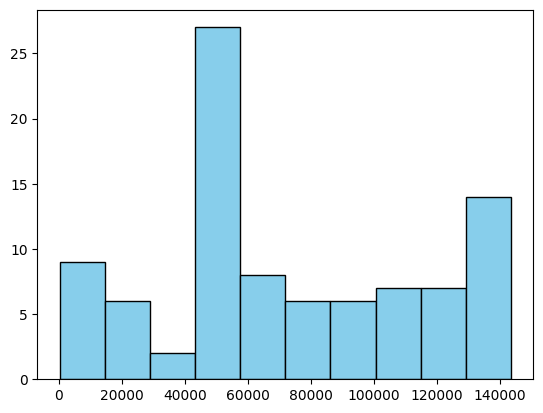

In [ ]:
data = pd.Series([word.i for word in pride if word.text == 'love'])

plt.hist(data, color='skyblue', edgecolor='black')

Or a density plot:

<Axes: ylabel='Density'>

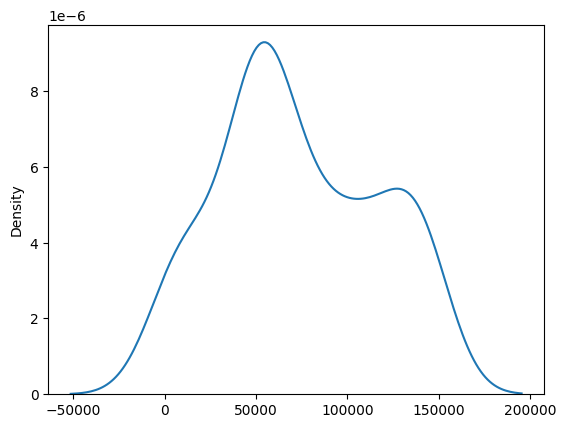

In [ ]:
sns.kdeplot(data)

We can take this idea and plot muliple words together to visualize their relationships in narrative time.

First we create a simple function:

In [ ]:
def getIndices(w):
  hist, bins = np.histogram(pd.Series([word.i for word in pride if word.text == w]), bins=50)
  return hist

Create a list of words and get their distibutions:

In [ ]:
wordList = ['love', 'hate', 'pride', 'prejudice']
wordIndices = [getIndices(w) for w in wordList]

Put those together in a data frame and generate subplots.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

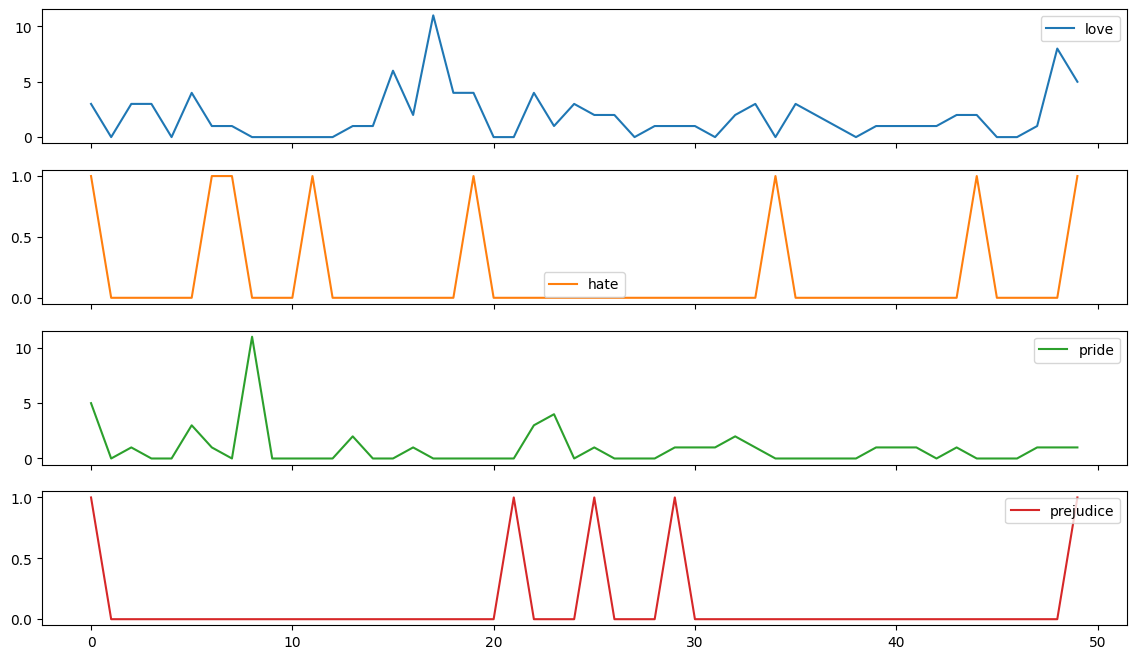

In [ ]:
wordsDF = pd.DataFrame(wordIndices, index=wordList).T
wordsDF.plot(subplots=True, figsize=(14,8))

And do the same with character names:

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

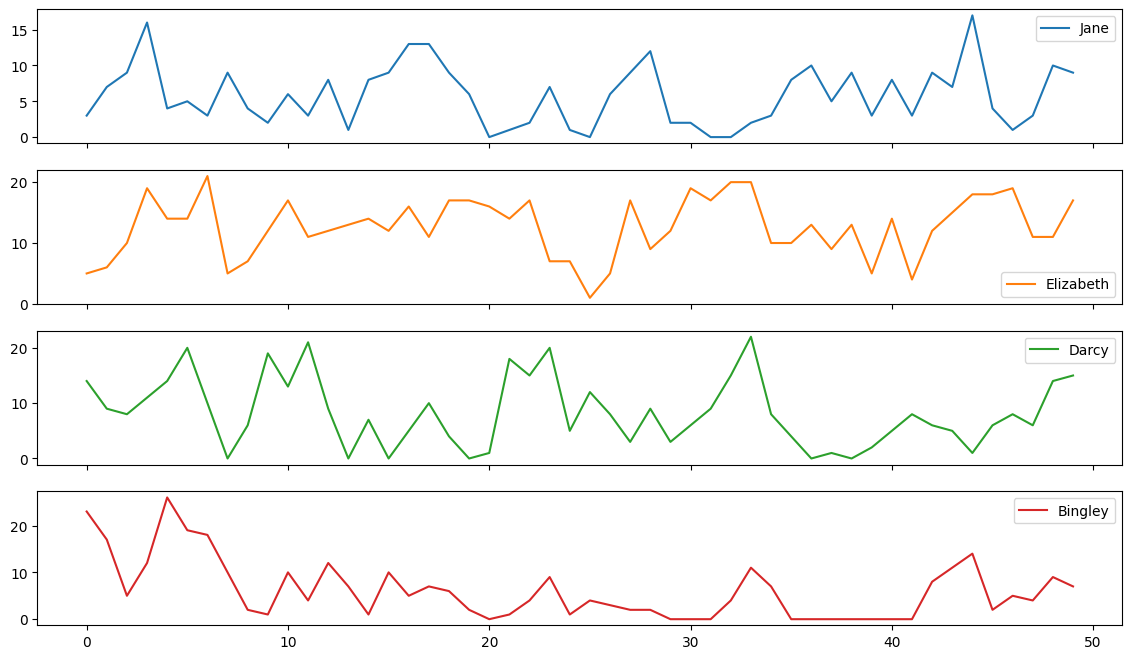

In [ ]:
wordList = ['Jane', 'Elizabeth', 'Darcy', 'Bingley']
wordIndices = [getIndices(w) for w in wordList]
wordsDF = pd.DataFrame(wordIndices, index=wordList).T
wordsDF.plot(subplots=True, figsize=(14,8))

We can also quanify those relationships by creating correlation matrix. In other words, do words follow similar trajectories (or tend to show up in the same histogram bins).

Again, we create a simple function:

In [ ]:
def narrativeTime(w, text, bin_number):
  return np.histogram(pd.Series([word.i for word in text
           if word.lemma_ == w]), bin_number)[0]

def wordCorrelation(wordlist, text, bin_number):
  df = pd.DataFrame([narrativeTime(w, text, bin_number)
                 for w in wordlist], index=wordlist)
  return df.T.corr().style.background_gradient(cmap='RdBu_r', vmin=-1, vmax=1)

And plot a correlation matrix. Here we use character names:

In [ ]:
wordCorrelation(['Jane', 'Elizabeth', 'Darcy', 'Bingley'],
                pride, bin_number=50)

,Jane,Elizabeth,Darcy,Bingley
Jane,1.000000,0.066035,-0.243912,0.180776
Elizabeth,0.066035,1.000000,0.065220,0.060713
Darcy,-0.243912,0.065220,1.000000,0.339794
Bingley,0.180776,0.060713,0.339794,1.000000


You can also change the bin number (or how big you want to chunk narrative time) and see how that changes the result:

In [ ]:
wordCorrelation(['Jane', 'Elizabeth', 'Darcy', 'Bingley'],
                pride, bin_number=100)

,Jane,Elizabeth,Darcy,Bingley
Jane,1.000000,0.007340,-0.097626,0.280229
Elizabeth,0.007340,1.000000,0.079248,0.108497
Darcy,-0.097626,0.079248,1.000000,0.250870
Bingley,0.280229,0.108497,0.250870,1.000000


### Term frequency distributions

This sort of thing you might have seen seen in the NLTK book or using other Python or R packages, but it's made even easier in spaCy. We're simply going to count the occurrences of words and divide by the total number of words in the document.

In [ ]:
inauguralLabels = [filename.split('.')[0] for filename in inaugural_subset['file']]

In [ ]:
# Create a Pandas Data Frame with each word counted in each document,
# divided by the length of the document.
inauguralSeries = [pd.Series(Counter(
                    [word.text.strip().lower()
                     for word in doc]))/len(doc)
                     for doc in inaugural_sub]
seriesDict = {label: series for label, series in zip(inauguralLabels, inauguralSeries)}
inauguralDf = pd.DataFrame(seriesDict).T.fillna(0)

In [ ]:
inauguralDf.head()

,!,"""",$,','d,'ll,'m,'re,'s,'ve,...,yourselfxand,yourselves,youth,zealously,—,’ll,’m,’re,’s,’ve
1901-McKinley,0.000408,0.004896,0.000408,0.0,0.0,0.0,0.0,0.0,0.000408,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1905-Roosevelt,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000917,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909-Taft,0.000000,0.000684,0.000171,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1913-Wilson,0.000526,0.001052,0.000000,0.0,0.0,0.0,0.0,0.0,0.002630,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1917-Wilson,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.001208,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can easily slice this data frame with words we're interested in, and plot those words across the corpus. For example, let's look at the proportions of the words *America* and *world*:

<Axes: >

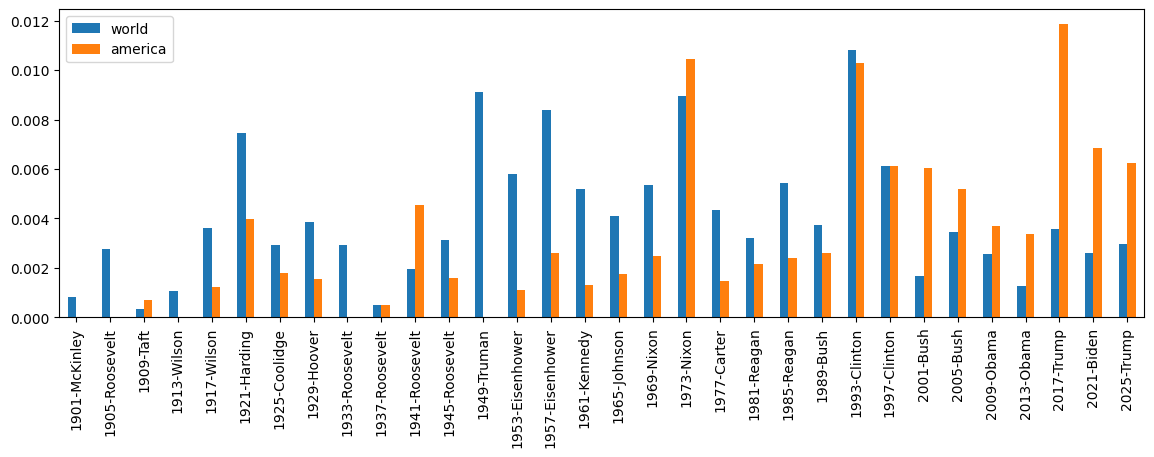

In [ ]:
inauguralDf[['world', 'america']].plot(kind='bar', figsize=(14,4))

We can even compute, say the ratio of uses of the word *America* to uses of the word *world*.

<Axes: >

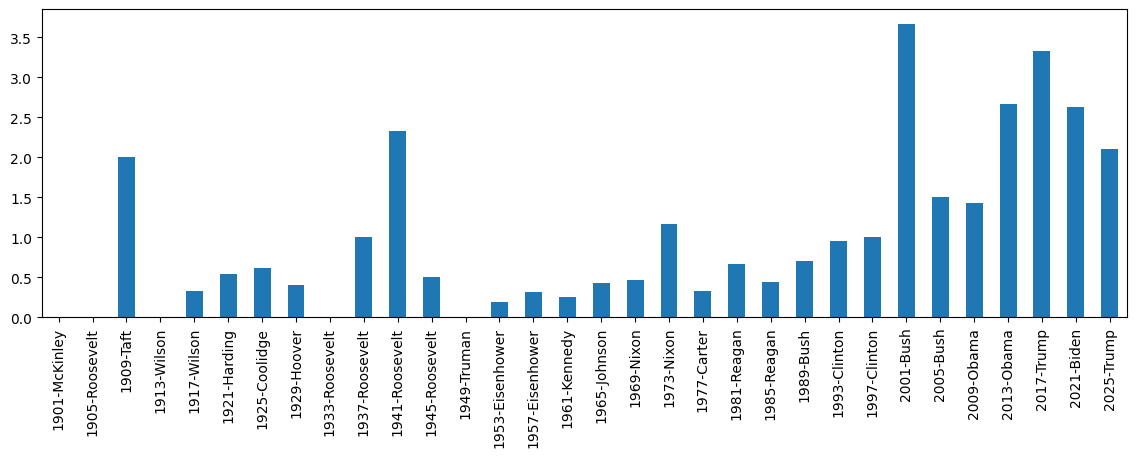

In [ ]:
americaWorldRatio = inauguralDf['america']/inauguralDf['world']
americaWorldRatio.plot(kind='bar', figsize=(14,4))

## Exploring sentences

As with tokens, we can easily count the number of sentences in a text:

In [ ]:
len(list(pride.sents))

5878

You can also iterate over the sentences. `doc.sents` is a generator object, so we can use `next()`:

In [ ]:
next(pride.sents)

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.

Or you can force it into a list, and then do things with it, like finding the last sentence in each text:

In [ ]:
prideSents = list(pride.sents)
prideSents[-1]

Darcy, as well as Elizabeth, really loved them; and they were both ever sensible of the warmest gratitude towards the persons who, by bringing her into Derbyshire, had been the means of uniting them.

In [ ]:
list(grail.sents)[-1]

Christ!

We can also find the longest sentence(s) in *Pride and Prejudice*:

In [ ]:
prideSentenceLengths = [len(sent) for sent in prideSents]
[sent for sent in prideSents if len(sent) == max(prideSentenceLengths)]

[Every lingering struggle in his favour grew fainter and fainter; and in farther justification of Mr. Darcy, she could not but allow that Mr. Bingley, when questioned by Jane, had long ago asserted his blamelessness in the affair; that proud and repulsive as were his manners, she had never, in the whole course of their acquaintance--an acquaintance which had latterly brought them much together, and given her a sort of intimacy with his ways--seen anything that betrayed him to be unprincipled or unjust--anything that spoke him of irreligious or immoral habits; that among his own connections he was esteemed and valued--that even Wickham had allowed him merit as a brother, and that she had often heard him speak so affectionately of his sister as to prove him capable of some amiable feeling; that had his actions been what Mr. Wickham represented them, so gross a violation of everything right could hardly have been concealed from the world; and that friendship between a person capable of it

Or we find the lemmatized words that appear more in excamatory sentences by:


*   getting a list of sentences that contain an exclamation point
*   counting the lemmas in those sentences
*   getting a list of sentences that don't contain an exclamation point
*   couting the lemmas in those sentences



In [ ]:
excl = [sent for sent in pride.sents if '!' in sent.text]
exclCounts = pd.Series(Counter([word.lemma_ for sent in excl for word in sent if not word.is_punct and not word.is_space]))
noExcl = [sent for sent in pride.sents if '!' not in sent.text]
noExclCounts = pd.Series(Counter([word.lemma_ for sent in noExcl for word in sent if not word.is_punct and not word.is_space]))

Now, we subtract the counts of our non-excamatory words from the counts of excamatory words:

In [ ]:
(exclCounts - noExclCounts).sort_values(ascending=False).head(10)

,0
oh,83.0
Heaven,9.0
Lord,8.0
gracious,4.0
ah,2.0
fun,2.0
strange,2.0
merry,1.0
Poor,1.0
accomplish,1.0


### Average sentence lengths

Let's analyze average sentence length in the inaugural data. spaCy makes this really easy

In [ ]:
sentLengths = [ np.mean([len(sent) for sent in doc.sents]) for doc in inaugural_sub ]

<Axes: >

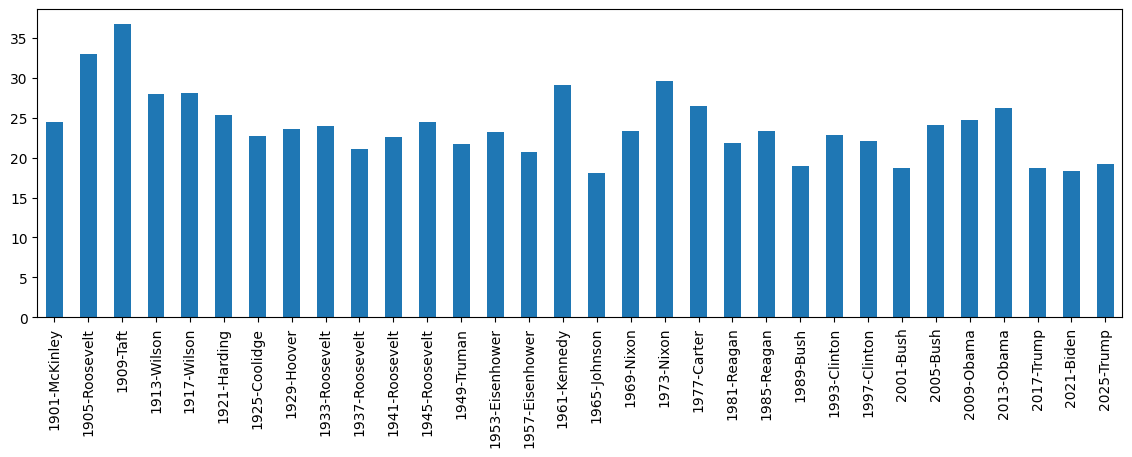

In [ ]:
pd.Series(sentLengths, index=inauguralLabels).plot(kind='bar', figsize=(14,4))

## Exploring named entities

Named entities can be accessed through `doc.ents`. Let's find all the types of named entities from _Monty Python and the Holy Grail_:

In [ ]:
set([w.label_ for w in grail.ents])

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

Place names?

We can count place names by specifying the GPE (Geopolitical entity) label. Note that some of the non-standard spelling can cause the misidentification of entities:

In [ ]:
grail_gpe = Counter([ent.text for ent in grail.ents if ent.label_ == 'GPE'])
grail_gpe.most_common(10)

[('England', 2),
 ('u--', 2),
 ('Mercea', 1),
 ('Augh', 1),
 ('Bristol', 1),
 ('y va', 1),
 ('U--', 1),
 ('Ewing', 1),
 ('Britain', 1),
 ('Concorde', 1)]

And do the same for *Pride and Prejudice*:

In [ ]:
pride_gpe = Counter([ent.text for ent in pride.ents if ent.label_ == 'GPE'])
pride_gpe.most_common(10)

[('Longbourn', 84),
 ('Netherfield', 69),
 ('London', 55),
 ('Charlotte', 53),
 ('Hertfordshire', 41),
 ('Derbyshire', 24),
 ('Brighton', 23),
 ('Bingley', 20),
 ('Hunsford', 20),
 ('Lambton', 10)]

What about those that are works of art?

In [ ]:
[ent.text for ent in grail.ents if ent.label_ == 'WORK_OF_ART']

['the Dragon of Angnor',
 'Zoot',
 "The Knights Who Say 'Ni'",
 'The Holy Hand Grenade of',
 'The Bridge of Death']

Organizations?

In [ ]:
grail_org = Counter([ent.text for ent in grail.ents if ent.label_ == 'ORG'])
grail_org.most_common(10)

[('Camelot', 16),
 ('eis', 4),
 ('Concorde', 3),
 ('the Court of Camelot', 2),
 ('Excalibur', 2),
 ('Knights of the Round Table', 2),
 ('Black Beast', 2),
 ('Pendragon', 1),
 ('hiyaah!', 1),
 ('Quoi', 1)]

How about groups of people?

In [ ]:
pride_norp = Counter([ent.text for ent in pride.ents if ent.label_ == 'NORP'])
pride_norp.most_common(10)

[('Christian', 2),
 ('Irish', 1),
 ('Italian', 1),
 ('British', 1),
 ('Spanish', 1),
 ('shrewish', 1),
 ('French', 1)]

"French" here refers to French _people_, not the French language. We can verify that by getting all the sentences in which this particular type of entity occurs:

In [ ]:
frenchPeople = [ent for ent in grail.ents if ent.label_ == 'NORP' and ent.text.strip() == 'French']
[ent.sent for ent in frenchPeople]

[I'm French!,
 Well, now, uh, Launcelot, Galahad, and I, uh, wait until nightfall, and then leap out of the rabbit, taking the French, uh, by surprise.,
 The ferocity of the French taunting took him completely by surprise, and Arthur became convinced that a new strategy was required if the quest for the Holy Grail were to be brought to a successful conclusion.,
 So, we French fellows outwit you a second time!,
 So, you think you could out-clever us French folk with your silly knees-bent running about advancing behaviour?!,
 French persons! ...]

An alternative method for extracting entities us to use the `ent_type` attribute:

In [ ]:
bennet = [w for w in pride if w.text == 'Bennet'][0]

In [ ]:
bennet.ent_type

380

In [ ]:
pride_person = Counter([w.text for w in pride if w.ent_type == 380])
pride_person.most_common(10)

[('Elizabeth', 633),
 ('Darcy', 415),
 ('Bennet', 320),
 ('Jane', 291),
 ('Bingley', 260),
 ('Wickham', 193),
 ('Collins', 179),
 ('Lydia', 170),
 ('Catherine', 126),
 ('Lady', 96)]

This is the equivalent of adding the trailing underscore to `ent_type_` and specifying `PERSON` as the type.

In [ ]:
pride_person = Counter([w.text for w in pride if w.ent_type_ == 'PERSON'])
pride_person.most_common(10)

[('Elizabeth', 633),
 ('Darcy', 415),
 ('Bennet', 320),
 ('Jane', 291),
 ('Bingley', 260),
 ('Wickham', 193),
 ('Collins', 179),
 ('Lydia', 170),
 ('Catherine', 126),
 ('Lady', 96)]

This method also allows for the extraction of "non-entities":

In [ ]:
set([(w.text, w.rank) for w in pride[:2000] if w.rank > 15000 and w.ent_type == 0])

{('Impossible', 16133),
 ('acquaintance', 18881),
 ('acquaintances', 18881),
 ('acquainted', 16913),
 ('amends', 18142),
 ('amusement', 15452),
 ('astonishment', 18655),
 ('circumspection', 19379),
 ('coughing', 18190),
 ('exclamation', 16214),
 ('extracts', 16883),
 ('flatter', 18049),
 ('fretfully', 18446744073709551615),
 ('hypocritical', 16156),
 ('ignorant', 15665),
 ('impatiently', 19207),
 ('neices', 18446744073709551615),
 ('objection', 17799),
 ('rightful', 15758),
 ('sarcastic', 17760),
 ('scolding', 19755),
 ('scrupulous', 18253),
 ('stared', 15504),
 ('teasing', 19479),
 ('tumult', 17221),
 ('universally', 19938),
 ('whichever', 18341)}

## Parts of speech

Each word already has a part of speech and a tag associated with it. Here's a list of all the parts of speech in _Pride and Prejudice_:

In [ ]:
# Make a quick-and-dirty lookup table of POS IDs,
# since the default representation of a POS is numeric.
tagDict = {w.pos: w.pos_ for w in pride}
tagDict

{95: 'PRON',
 87: 'AUX',
 90: 'DET',
 92: 'NOUN',
 86: 'ADV',
 100: 'VERB',
 97: 'PUNCT',
 98: 'SCONJ',
 84: 'ADJ',
 85: 'ADP',
 89: 'CCONJ',
 93: 'NUM',
 96: 'PROPN',
 94: 'PART',
 91: 'INTJ',
 101: 'X',
 99: 'SYM'}

It's fun to compare the distribution of parts of speech in each text:

<Axes: >

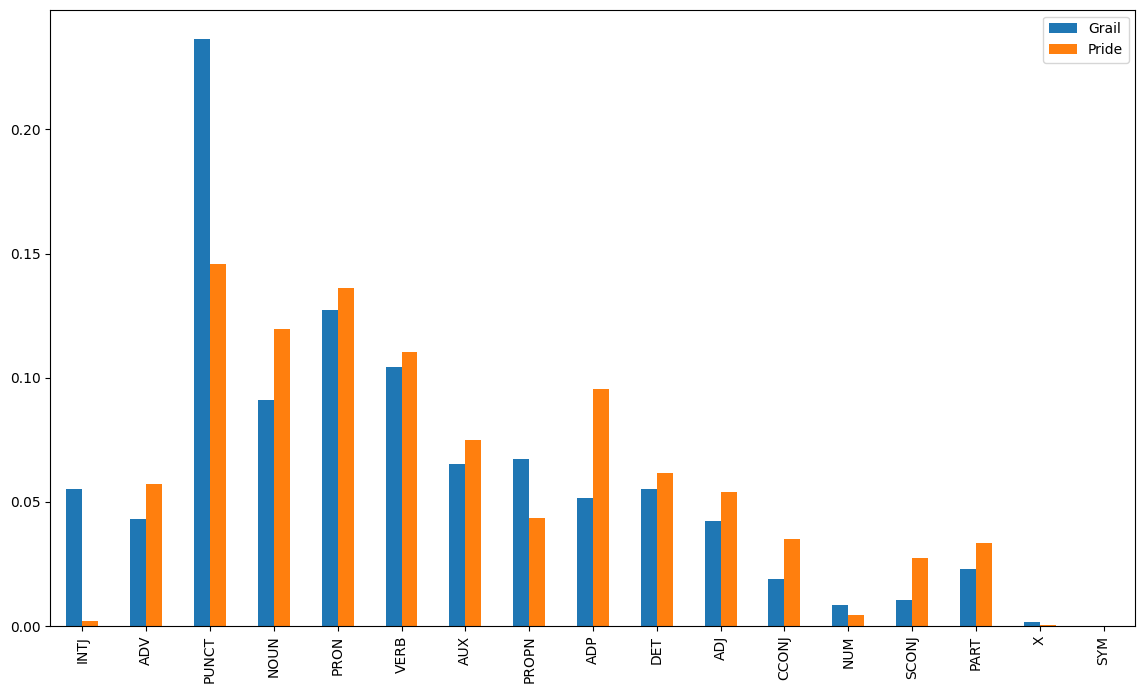

In [ ]:
grailPOS = pd.Series(grail.count_by(spacy.attrs.POS))/len(grail)
pridePOS = pd.Series(pride.count_by(spacy.attrs.POS))/len(pride)

df = pd.DataFrame([grailPOS, pridePOS], index=['Grail', 'Pride'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar', figsize=(14,8))

Now we can see, for instance, what the most common pronouns might be:

In [ ]:
pridePro = [w for w in pride if w.pos_ == 'PRON']
Counter([w.text.strip() for w in pridePro]).most_common(10)

[('her', 2137),
 ('I', 2067),
 ('she', 1383),
 ('it', 1287),
 ('his', 1191),
 ('you', 1149),
 ('he', 1098),
 ('him', 764),
 ('my', 599),
 ('which', 532)]

In [ ]:
grailPro = [w for w in grail if w.pos_ == 'PRON']
Counter([w.text.strip() for w in grailPro]).most_common(10)

[('I', 240),
 ('you', 202),
 ('it', 106),
 ('your', 75),
 ('What', 65),
 ('You', 61),
 ('We', 60),
 ('that', 58),
 ('we', 57),
 ('me', 46)]

Let's try this on the level of a sentence. First, let's get all the sentences in which Sir Robin is explicitly mentioned:

In [ ]:
robinSents = [sent for sent in grail.sents if 'Sir Robin' in sent.text]
robinSents

[Then I dub you Sir Bedevere, Knight of the Round Table The wise Sir Bedevere was the first to join King Arthur's knights, but other illustrious names were soon to follow: Sir Lancelot the Brave; Sir Gallahad the Pure; and Sir Robin the-not-quite-so-brave-as-Sir-Lancelot, who had nearly fought the Dragon of Angnor, who had nearly stood up to the vicious Chicken of Bristol, and who had personally wet himself at the Battle of Badon Hill; and the aptly named Sir Not-appearing-in-this-film.,
 Frank The Tale of Sir Robin.,
 Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.,
 Bravely bold Sir Robin, rode forth from Camelot.,
 He was not afraid to die, O brave Sir Robin.,
 Brave, brave, brave, brave Sir Robin!,
 To have his kneecaps split, and his body burned away, And his limbs all hacked and mangled, brave Sir Robin!,
 He is brave Sir Robin, brave Sir Robin, who-- Shut up!,
 He's scarper Brave Sir Robin ran away.,
 Yes, brave Sir Robin turned abo

Now let's analyze just one of these sentences.

In [ ]:
r2 = robinSents[2]
r2

Sir Robin rode north, through the dark forest of Ewing, accompanied by his favorite minstrels.

Let's look at the tags and parts of speech:

In [ ]:
for word in r2:
    print(word, word.tag_, word.pos_)

Sir NNP PROPN
Robin NNP PROPN
rode VBD VERB
north RB ADV
, , PUNCT
through IN ADP
the DT DET
dark JJ ADJ
forest NN NOUN
of IN ADP
Ewing NNP PROPN
, , PUNCT
accompanied VBN VERB
by IN ADP
his PRP$ PRON
favorite JJ ADJ
minstrels NNS NOUN
. . PUNCT


### Dependency parsing
Now let's analyze the structure of the sentence.

This sentence has lots of properties:

In [ ]:
[prop for prop in dir(r2) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'id',
 'id_',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [ ]:
r2.root

rode

That root has children:

In [ ]:
list(r2.root.children)

[Robin, north, ,, through, ,, accompanied, .]

Let's see all of the children for each word:  

In [ ]:
for word in r2:
    print(word, ': ', str(list(word.children)))

Sir :  []
Robin :  [Sir]
rode :  [Robin, north, ,, through, ,, accompanied, .]
north :  []
, :  []
through :  [forest]
the :  []
dark :  []
forest :  [the, dark, of]
of :  [Ewing]
Ewing :  []
, :  []
accompanied :  [by]
by :  [minstrels]
his :  []
favorite :  []
minstrels :  [his, favorite]
. :  []


A full parse-tree for a sentence can be displayed using `displacy`:

In [ ]:
spacy.displacy.render(r2, style='dep', jupyter=True)

You can already see how useful this might be. Since adjectives are typically children of the things they describe, we can get approximations for adjectives that describe characters. How is Sir Robin described?

In [ ]:
for sent in robinSents:
    for word in sent:
        if 'Robin' in word.text:
            for child in word.children:
                if child.pos_ == 'ADJ':
                    print(child)

brave
bold
brave
brave
brave
brave
brave


Now let's do something similar for *Pride and Prejudice*. First, we'll use named entity extraction to get a list of the most frequently mentioned characters:  

In [ ]:
Counter([w.text.strip() for w in pride.ents if w.label_ == 'PERSON']).most_common(10)

[('Elizabeth', 625),
 ('Darcy', 408),
 ('Jane', 289),
 ('Bennet', 260),
 ('Bingley', 259),
 ('Wickham', 185),
 ('Collins', 179),
 ('Lydia', 167),
 ('Lizzy', 94),
 ('Gardiner', 94)]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find:

In [ ]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.text]
    adjectives = []
    for sent in sents:
        for word in sent:
            if character in word.text:
                for child in word.children:
                    if child.pos_ == 'ADJ':
                        adjectives.append(child.text.strip())
    return Counter(adjectives).most_common(10)

We'll try it on Mr. Darcy:

In [ ]:
adjectivesDescribingCharacters(pride, 'Darcy')

[('late', 7),
 ('present', 2),
 ('superior', 1),
 ('poor', 1),
 ('little', 1),
 ('disagreeable', 1)]

Now let's do the same sort of thing, but look for associated verbs. First, let's get all the sentences in which Elizabeth is mentioned:  

In [ ]:
elizabethSentences = [sent for sent in pride.sents if 'Elizabeth' in sent.text]

And we can peek at one of them:

In [ ]:
elizabethSentences[3]

Mr. Darcy walked off; and Elizabeth remained with no very cordial feelings toward him.

In [ ]:
spacy.displacy.render(elizabethSentences[3], style='dep', jupyter=True)

We want the verb associated with Elizabeth, _remained_, not the root verb of the sentence, _walked_, which is associated with Mr. Darcy. So let's write a function that will walk up the dependency tree from a character's name until we get to the first verb. We'll use lemmas instead of the conjugated forms to collapse _remain_, _remains_, and _remained_ into one verb: _remain_.

In [ ]:
def verbsForCharacters(text, character):
    sents = [sent for sent in pride.sents if character in sent.text]
    charWords = []
    for sent in sents:
        for word in sent:
            if character in word.text:
                charWords.append(word)
    charAdjectives = []
    for word in charWords:
        # Start walking up the list of ancestors
        # Until we get to the first verb.
        for ancestor in word.ancestors:
            if ancestor.pos_.startswith('V'):
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [ ]:
elizabethVerbs = verbsForCharacters(pride, 'Elizabeth')
elizabethVerbs

[('say', 65),
 ('have', 30),
 ('see', 24),
 ('cry', 24),
 ('reply', 22),
 ('feel', 19),
 ('look', 18),
 ('make', 18),
 ('think', 10),
 ('find', 10),
 ('go', 10),
 ('give', 10),
 ('receive', 9),
 ('begin', 9),
 ('walk', 8),
 ('listen', 8),
 ('take', 8),
 ('help', 8),
 ('speak', 8),
 ('turn', 7)]

In [ ]:
darcyVerbs = verbsForCharacters(pride, 'Darcy')
janeVerbs = verbsForCharacters(pride, 'Jane')

We can now merge these counts into a single table, and then we can visualize it with Pandas.

<Axes: >

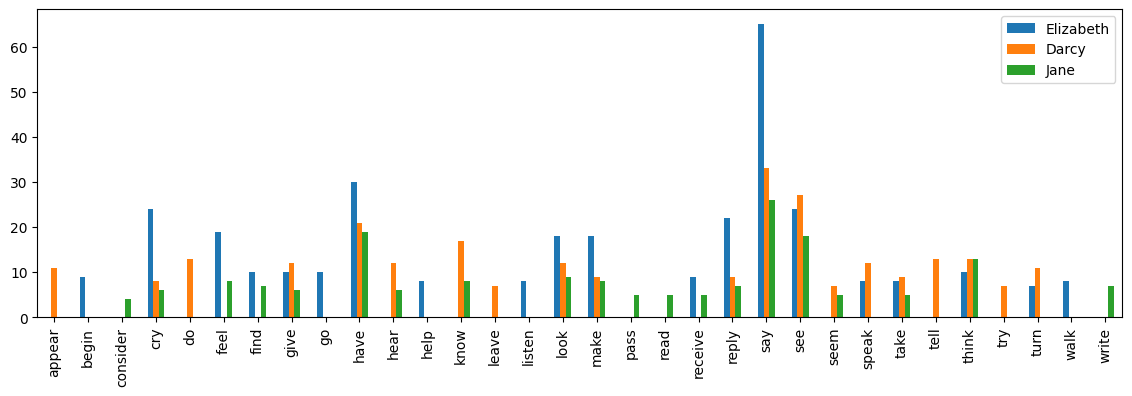

In [ ]:
def verbsToMatrix(verbCounts):
    """
    Takes verb counts given by verbsForCharacters
    and makes Pandas Series out of them, suitabe for combination in
    a DataFrame.
    """
    return pd.Series({t[0]: t[1] for t in verbCounts})

verbsDF = pd.DataFrame({'Elizabeth': verbsToMatrix(elizabethVerbs),
                        'Darcy': verbsToMatrix(darcyVerbs),
                        'Jane': verbsToMatrix(janeVerbs)}).fillna(0)
verbsDF.plot(kind='bar', figsize=(14,4))

We can do this with ngrams, too, with some fancy Python magic:

## Word embeddings (word vectors)

Word embeddings (word vectors) are numeric representations of words, usually generated via dimensionality reduction on a word cooccurrence matrix for a large corpus. The vectors SpaCy uses are the [GloVe](http://nlp.stanford.edu/projects/glove/) vectors, Stanford's Global Vectors for Word Representation. These vectors can be used to calculate semantic similarity between words and documents.

In [ ]:
peanut, mockingbird, woodpecker, horse = nlp('peanut'), nlp('mockingbird'), nlp('woodpecker'), nlp('horse')

In [ ]:
peanut.similarity(horse)

0.1126651235583395

In [ ]:
mockingbird.similarity(horse)

0.3804972983434462

In [ ]:
woodpecker.similarity(mockingbird)

0.7040241153596377

Let's look at vectors for _Pride and Prejudice_. First, let's get the first 150 nouns:

In [ ]:
prideNouns = [word for word in pride if word.pos_.startswith('N')][:150]

Now let's get vectors and labels for each of them:

In [ ]:
prideNounVecs = [word.vector for word in prideNouns]
prideNounLabels = [word.text.strip() for word in prideNouns]

In [ ]:
prideNounVecs[0].shape

(300,)

A single vector is 300-dimensional, so in order to plot it in 2D, it might help to reduce the dimensionality to the most meaningful dimensions. We can use Scikit-Learn to perform truncated singular value decomposition for latent semantic analysis (LSA).

In [ ]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(prideNounVecs)

Plot the results in a scatter plot:

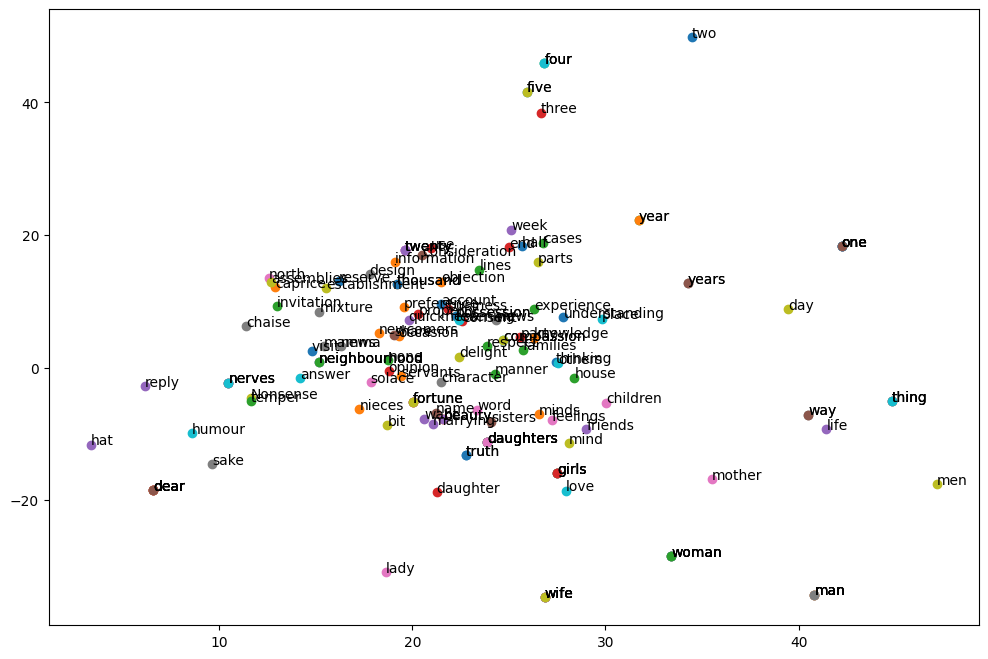

In [ ]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(xs)):
    ax.scatter(xs[i], ys[i])
    ax.annotate(prideNounLabels[i], (xs[i], ys[i]))

It is important to recognize that these are PRE-trained embeddings, and they are FIXED embeddings. This means that the above plot shows the relationships between these words based on a model trained on a large data set of modern, web-based English. They are not contextual and they are not trained on *Pride and Prejudice* specifically. So they don't capture local, collocational information. In other words, this doesn't tell us anything about these word relationships in this specific text.

## Document vectorization

This uses a non-semantic technique for vectorizing documents, just using bag-of-words. We won't need any of the fancy features of SpaCy for this, just scikit-learn. We'll use a subset of the Inaugural Address Corpus that contains 20th and 21st century inaugural addresses.

First, we'll vectorize the corpus using scikit-learn's `TfidfVectorizer` class. This creates a matrix of word frequencies.

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
lsa = TruncatedSVD(n_components=2)

In [ ]:
tfidfOut = tfidf.fit_transform(inaugural_subset['text']).toarray()

In [ ]:
tfidfOut.shape

(32, 6304)

In [ ]:
lsaOut = lsa.fit_transform(tfidfOut)

In [ ]:
# While we're at it, let's make a list of the lengths, so we can use them to plot dot sizes.
lengths = [len(text)/100 for text in inaugural_subset['text']]
# Add a manually compiled list of presidential party affiliations,
# So that we can use this to color our dots.
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbbrbr'

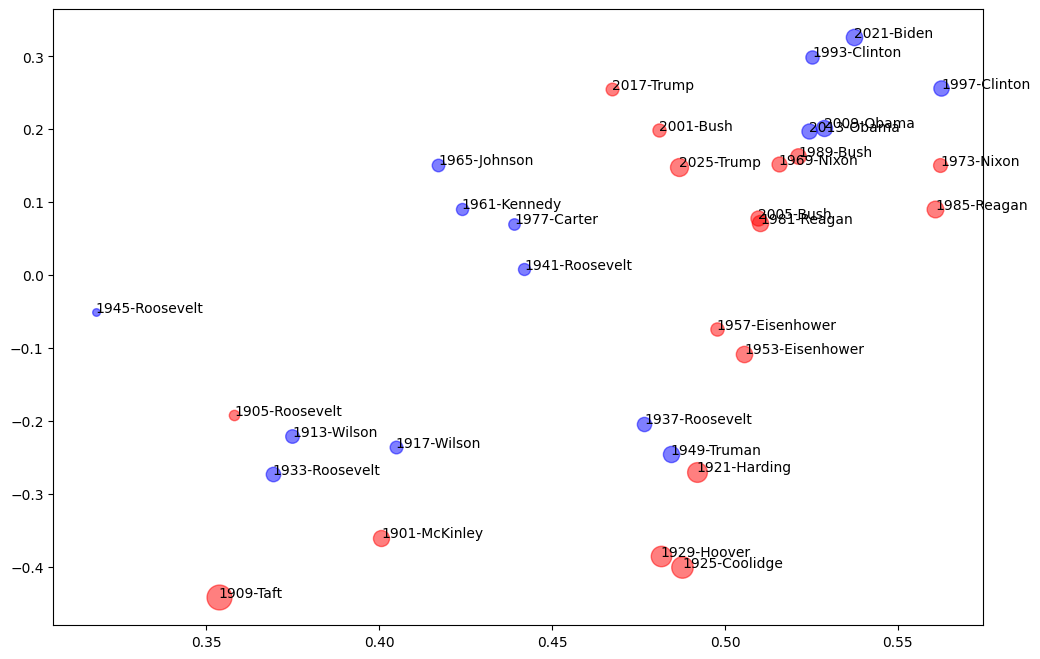

In [ ]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(xs)):
    ax.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    ax.annotate(inauguralLabels[i], (xs[i], ys[i]))

## Document similarity matrix

Using the `.similarity()` method from earlier that uses word vectors, we can very easily compute the document similarity between all the documents in our corpus.

In [ ]:
similarities = [ [doc.similarity(other) for other in inaugural_sub] for doc in inaugural_sub ]
similaritiesDf = pd.DataFrame(similarities, columns=inauguralLabels, index=inauguralLabels)

In [ ]:
similaritiesDf.head()

,1901-McKinley,1905-Roosevelt,1909-Taft,1913-Wilson,1917-Wilson,1921-Harding,1925-Coolidge,1929-Hoover,1933-Roosevelt,1937-Roosevelt,...,1989-Bush,1993-Clinton,1997-Clinton,2001-Bush,2005-Bush,2009-Obama,2013-Obama,2017-Trump,2021-Biden,2025-Trump
1901-McKinley,1.000000,0.987365,0.995432,0.989112,0.983638,0.991782,0.991734,0.994526,0.993525,0.987652,...,0.958756,0.970471,0.982822,0.971621,0.992647,0.974569,0.970873,0.973334,0.944748,0.970703
1905-Roosevelt,0.987365,1.000000,0.980783,0.996775,0.995456,0.994845,0.995364,0.983059,0.994438,0.994806,...,0.983220,0.989005,0.991112,0.990983,0.990673,0.992865,0.991046,0.987128,0.973204,0.986710
1909-Taft,0.995432,0.980783,1.000000,0.984900,0.975836,0.986102,0.989189,0.994101,0.991636,0.982200,...,0.948686,0.957147,0.973881,0.961718,0.985175,0.965097,0.960569,0.959339,0.929212,0.959301
1913-Wilson,0.989112,0.996775,0.984900,1.000000,0.993909,0.995599,0.995733,0.984889,0.995785,0.994650,...,0.983091,0.986423,0.991013,0.989191,0.991266,0.991640,0.987859,0.985931,0.970967,0.985480
1917-Wilson,0.983638,0.995456,0.975836,0.993909,1.000000,0.992051,0.993522,0.978707,0.991902,0.993764,...,0.982710,0.988784,0.988943,0.989487,0.986456,0.992599,0.992866,0.988749,0.975778,0.987774


We can create a heatmap of the similarities:

<Axes: >

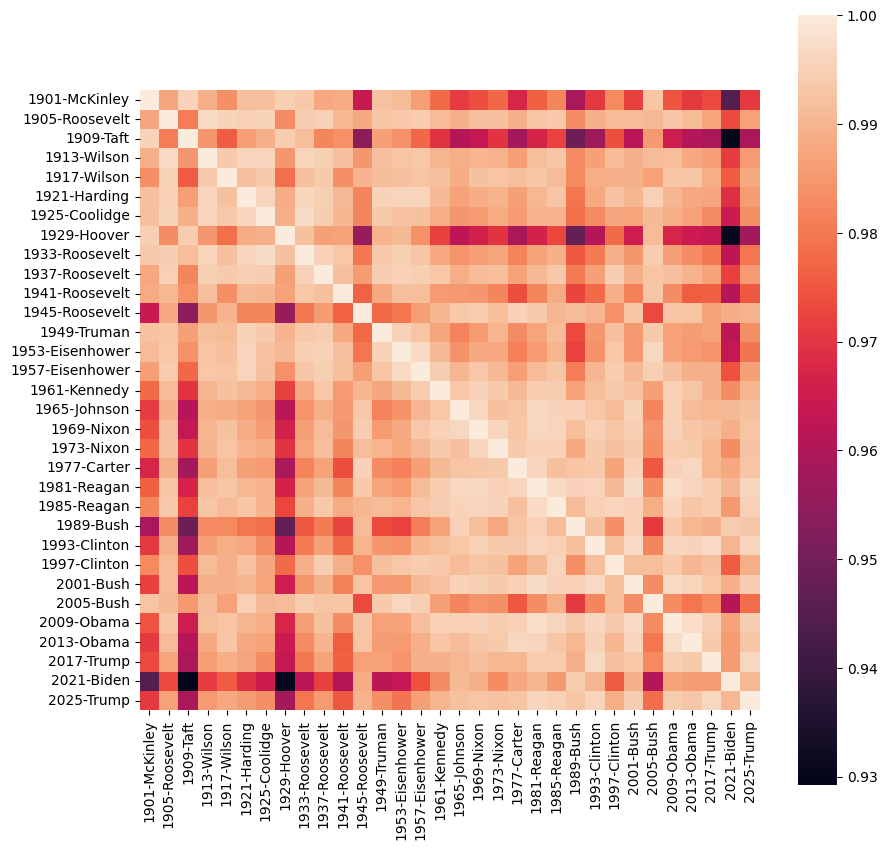

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(similaritiesDf, square=True, annot=False, ax=ax)

But it is sometimes difficult to see relationships, particularly when the documents are all of a very codified genre. An alternative is to use a clustermap:

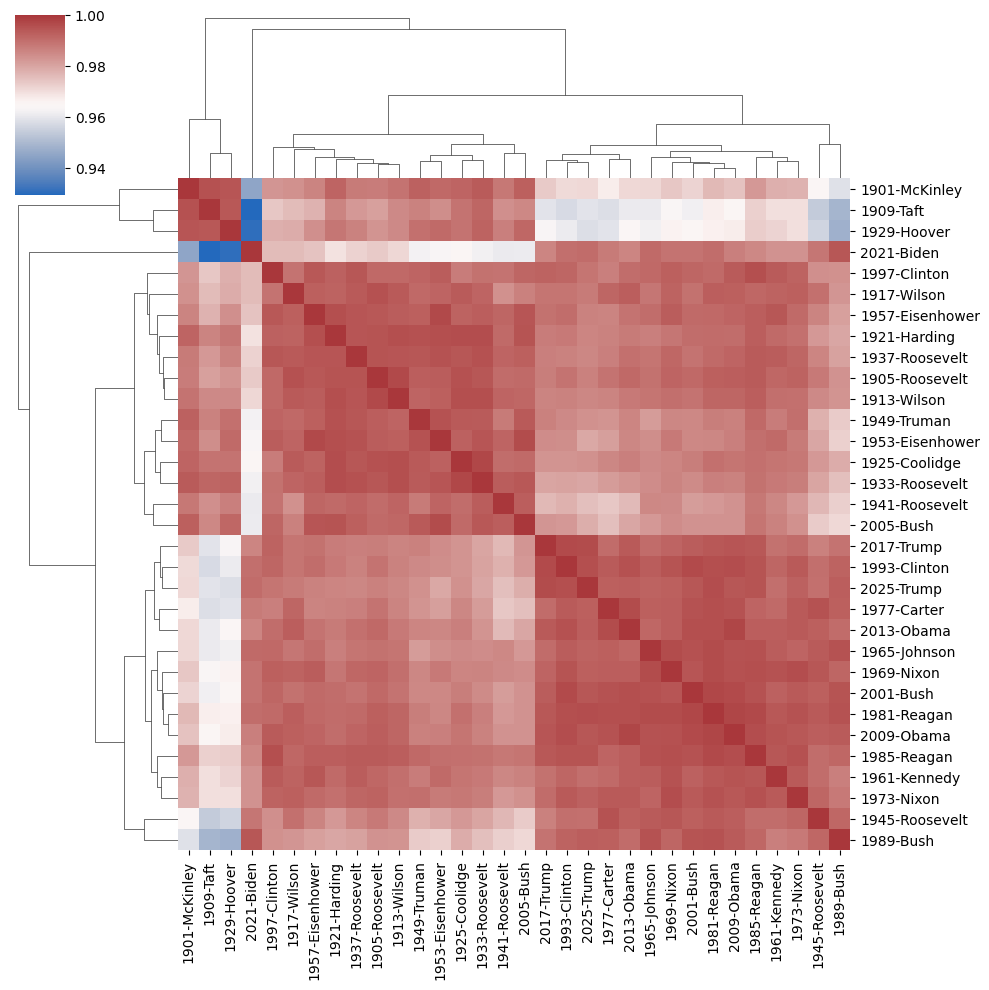

In [ ]:
sns.clustermap(similaritiesDf, cmap="vlag")

---

## 💬 Discussion Questions

After working through this comprehensive exploration of spaCy, reflect on these questions:

1. **Dependency Parsing vs. Bag-of-Words**: The notebook demonstrates both dependency parsing (walking up ancestor trees to find verbs associated with characters) and bag-of-words approaches (TF-IDF vectorization). What kinds of research questions require syntax-aware methods vs. simple frequency counts? When is the added complexity of parsing worth it?

2. **Pre-trained Embeddings**: The word vectors used here (GloVe) are pre-trained on modern web text, not on *Pride and Prejudice* or *Monty Python*. How does this affect interpretation? Would character embeddings from these specific texts tell a different story than the general-purpose embeddings?

3. **Named Entity Errors**: The notebook shows that non-standard spelling causes NER errors (e.g., in *Monty Python*). How should you handle systematic NER failures in historical texts, dialects, or creative writing? When is manual correction worth it vs. accepting imperfect automation?

4. **Token Attributes and Exploration**: spaCy tokens have dozens of attributes (`.i`, `.idx`, `.prefix_`, `.ent_type_`, etc.). How do you decide which attributes matter for your question? What's the risk of exploratory "fishing" through attributes vs. hypothesis-driven analysis?

5. **Computational Scalability**: This notebook processes two literary texts and a small inaugural corpus fairly quickly (~23 seconds for Pride & Prejudice). How would these methods scale to thousands of texts? Which operations would become bottlenecks?

6. **Interpretation vs. Description**: Many examples here are descriptive ("What adjectives describe Darcy?"). How do you move from description to interpretation? When does counting adjectives or verbs actually tell you something meaningful about character, narrative, or style?

---

## 🔬 Ideas for Further Experimentation

If you want to extend this exploration of spaCy, try these projects:

1. **Genre Comparison**: Compare dependency patterns across genres. Do noun-verb relationships differ between fiction, drama, and political speeches? Extract subject-verb-object triples and compare their distributions.

2. **Historical Linguistic Change**: Use the inaugural corpus to track changes over time in named entity types (do more recent speeches mention more organizations? fewer places?), sentence complexity, or pronoun usage. Connect to the time series methods from Mini Lab 7.

3. **Character Network Analysis**: Build a character co-occurrence network from *Pride and Prejudice*. When do characters appear in the same sentences? Use this to map social relationships and narrative centrality.

4. **Sentiment and Dependency**: Combine sentiment analysis (from Mini Labs 11-12) with dependency parsing. Do positive/negative adjectives modify different types of nouns? Are certain verbs associated with emotional language?

5. **Custom NER Training**: Train a custom spaCy NER model on a specific domain (e.g., recognize character names in your own corpus, identify technical terms in scientific texts). Compare performance to the general-purpose model.

6. **Collocations from Dependencies**: Use dependency relationships to find meaningful collocations beyond simple co-occurrence windows. For example, find all adjective-noun pairs, verb-object pairs, or subject-verb-adverb triples. Compare to the n-gram approach from Mini Lab 6.

---

# Learn More

 - [spaCy Homepage](https://spacy.io/)
 - [What You Can Learn About Food By Analyzing a Million Yelp Reviews](http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb)

# See Also

 - [Textacy, higher-level NLP based on spaCy](https://github.com/chartbeat-labs/textacy)
 - [tmtoolkit: Text mining and topic modeling toolkit](https://tmtoolkit.readthedocs.io/en/latest/)